<a href="https://colab.research.google.com/github/muskaansandhu/Datasci223-Final-Project/blob/main/Model_Building_MS_DataSci223FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

#Installing all the required packages
%pip install -q numpy pandas matplotlib seaborn scikit-learn tensorflow
import os
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Reading in the dataset
from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['hf_dataset (2).csv']))

Saving hf_dataset.csv to hf_dataset (2).csv


In [4]:
#Viewing the dataset
print(df)

      age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    75.0        0                       582         0                 20   
1    55.0        0                      7861         0                 38   
2    65.0        0                       146         0                 20   
3    50.0        1                       111         0                 20   
4    65.0        1                       160         1                 20   
..    ...      ...                       ...       ...                ...   
294  62.0        0                        61         1                 38   
295  55.0        0                      1820         0                 38   
296  45.0        0                      2060         1                 60   
297  45.0        0                      2413         0                 38   
298  50.0        0                       196         0                 45   

     high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \

# ***Model 1: Logistic Regression ***


In [7]:
#DATA PREPROCESSING

  #Features vs. Target Variable
X = df.drop(['DEATH_EVENT', 'time_weeks'], axis=1)
Y = df['DEATH_EVENT']

  #Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X)

  #Train, Test Split ~ 80-20

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_scaled, Y, test_size=0.20, random_state=42)
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
#MODEL BUILDING LOGISTIC REGRESSION

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
c_space=np.logspace(-5, 2, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2'], 'solver':['newton-cg', 'lbfgs', 'liblinear'], 'max_iter':[100,1000,10000]}
logistic_regression = LogisticRegression()
logistic_regression_cv = GridSearchCV(logistic_regression, param_grid, cv=kf)
logistic_regression_cv.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
450 fits failed out of a total of 1350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: S

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-05, 3.16227766e-05, 1.00000000e-04, 3.16227766e-04,
       1.00000000e-03, 3.16227766e-03, 1.00000000e-02, 3.16227766e-02,
       1.00000000e-01, 3.16227766e-01, 1.00000000e+00, 3.16227766e+00,
       1.00000000e+01, 3.16227766e+01, 1.00000000e+02]),
                         'max_iter': [100, 1000, 10000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']})

In [9]:
#DETERMINING THE BEST MODEL HYPERPARAMETERS
print(f"Best Logistic Regression Parameters: {logistic_regression_cv.best_params_}")
print(f"Best Logistic Regression Accuracy Score: {logistic_regression_cv.best_score_}")

Best Logistic Regression Parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Logistic Regression Accuracy Score: 0.8406914893617022


In [10]:
#FITTING THE TRAINING DATA ON BEST MODEL HYPERPARAMETERS
best_logistic_regression_model = LogisticRegression(C=0.1, max_iter= 100, penalty = "l1", solver = "liblinear")
best_logistic_regression_model.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [11]:
#EVALUATING MODEL PERFORMANCE ON TEST HOLDOUT
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
y_test_pred = best_logistic_regression_model.predict(X_test)
validation_score = accuracy_score(y_test, y_test_pred)
print(f"Test Hold-out Score: {validation_score}")
prec = precision_score(y_test, y_test_pred, average='macro', zero_division = 1)
print(f"Precision: {prec}")
rec = recall_score(y_test, y_test_pred, average = 'macro')
print(f"Recall: {rec}")
f1 = f1_score(y_test, y_test_pred, average = 'macro')
print(f"f1: {f1}")


Test Hold-out Score: 0.8
Precision: 0.8248974008207934
Recall: 0.7714285714285714
f1: 0.7802197802197802


In [12]:
#EVALUATING MCC & AUC
from sklearn.metrics import precision_recall_curve, roc_auc_score, matthews_corrcoef, auc
mcc_lr_model = matthews_corrcoef(y_test, y_test_pred)
print(f"Matthews Correlation Coefficient: {mcc_lr_model}")

y_probs = best_logistic_regression_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)
auc_roc = roc_auc_score(y_test, y_probs)
print(f"Precision-Recall AUC: {pr_auc}")
print(f"AUC ROC: {auc_roc}")

Matthews Correlation Coefficient: 0.5939240266756143
Precision-Recall AUC: 0.816183354550586
AUC ROC: 0.832


In [15]:
#LOOKING AT CONFUSION MATRIX

from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:" , "\n", cm_lr)

# TP rate
from sklearn.metrics import recall_score
tp_rate_lr = recall_score(y_test, y_test_pred)
print('TP Rate:', tp_rate_lr)

# TN rate
tn_rate_lr = cm_lr[0,0]/(cm_lr[0,0] + cm_lr[0,1])
print('TN Rate:', tn_rate_lr)

Confusion Matrix: 
 [[33  2]
 [10 15]]
TP Rate: 0.6
TN Rate: 0.9428571428571428


# **Model 2: Random Forest**

In [18]:
#Since we don't need to scale the data for random forest

X2_train, X2_test, y2_train, y2_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [19]:
#MODEL BUILDING FOR RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier
rf_param_grid = {'n_estimators': [50, 100, 150, 200], 'max_depth': [None, 10, 20],'min_samples_split': [2,4,6,8,10]}
random_forest = RandomForestClassifier()
random_forest_cv = GridSearchCV(random_forest, rf_param_grid, cv=kf)
random_forest_cv.fit(X2_train, y2_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [50, 100, 150, 200]})

In [20]:
#DETERMINING THE BEST MODEL HYPERPARAMETERS
print(f"Best Random Forest Parameters: {random_forest_cv.best_params_}")
print(f"Best Random Forest Accuracy Score: {random_forest_cv.best_score_}")

Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 6, 'n_estimators': 100}
Best Random Forest Accuracy Score: 0.8953900709219859


In [21]:
#FITTING THE TRAINING DATA ON BEST MODEL HYPERPARAMETERS
best_random_forest_model = RandomForestClassifier(max_depth=None, min_samples_split=6, n_estimators=100)
best_random_forest_model.fit(X2_train, y2_train)

RandomForestClassifier(min_samples_split=6)

In [22]:
#EVALUATING MODEL PERFORMANCE ON TEST HOLDOUT
rf_test_pred = best_random_forest_model.predict(X2_test)
validation_score_rf = accuracy_score(y2_test, rf_test_pred)
print(f"Test Hold-out Score: {validation_score_rf}")
prec_rf = precision_score(y2_test, rf_test_pred, average='macro', zero_division = 1)
print(f"Precision: {prec_rf}")
rec_rf = recall_score(y2_test, rf_test_pred, average = 'macro')
print(f"Recall: {rec_rf}")
f1_rf = f1_score(y2_test, rf_test_pred, average = 'macro')
print(f"f1: {f1_rf}")

Test Hold-out Score: 0.75
Precision: 0.7698863636363636
Recall: 0.7171428571428571
f1: 0.7221364618709478


In [23]:
#EVALUATING MCC & AUC
mcc_rf_model = matthews_corrcoef(y2_test, rf_test_pred)
print(f"Matthews Correlation Coefficient: {mcc_rf_model}")

rf_y_probs = best_random_forest_model.predict_proba(X2_test)[:, 1]
precision_rf, recall_rf, _ = precision_recall_curve(y2_test, rf_y_probs)
rf_pr_auc = auc(recall_rf, precision_rf)
rf_auc_roc = roc_auc_score(y2_test, rf_y_probs)
print(f"Precision-Recall AUC: {rf_pr_auc}")
print(f"AUC ROC: {rf_auc_roc}")

Matthews Correlation Coefficient: 0.48416483186574427
Precision-Recall AUC: 0.8102705073482414
AUC ROC: 0.848


In [24]:
#LOOKING AT CONFUSION MATRIX

cm_rf = confusion_matrix(y2_test, rf_test_pred)
print("Confusion Matrix:" , "\n", cm_rf)

# TP rate
tp_rate_rf = recall_score(y2_test, rf_test_pred)
print('TP Rate:', tp_rate_rf)

# TN rate
tn_rate_rf = cm_rf[0,0]/(cm_rf[0,0] + cm_rf[0,1])
print('TN Rate:', tn_rate_rf)

Confusion Matrix: 
 [[32  3]
 [12 13]]
TP Rate: 0.52
TN Rate: 0.9142857142857143


# **Feature Importance**

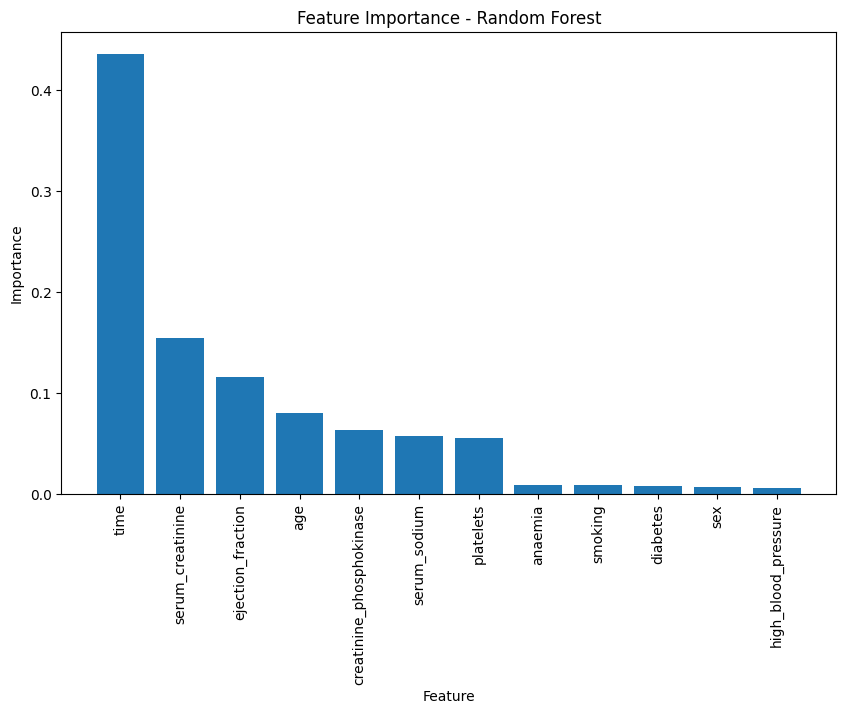

In [ ]:
#USING FEATURE IMPORTANCE FOR RANDOM FOREST

importances = best_random_forest_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_names)), importances[indices], align='center')
plt.xticks(range(len(feature_names)), np.array(feature_names)[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance - Random Forest')
plt.show()

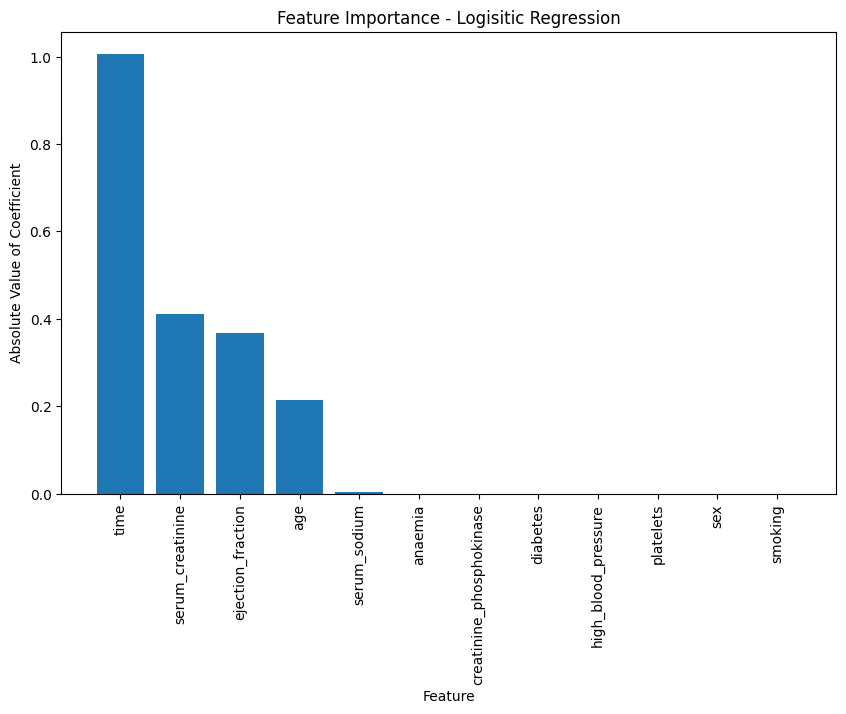

In [ ]:
#USING FEATURE IMPORTANCE FOR LOGISTIC REGRESSION

coefficients = best_logistic_regression_model.coef_[0]
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})


coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()


coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)


plt.figure(figsize=(10, 6))
plt.bar(coef_df['Feature'], coef_df['Abs_Coefficient'])
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Feature')
plt.ylabel('Absolute Value of Coefficient')
plt.title('Feature Importance - Logisitic Regression')
plt.show()

# **Random Forest Model w/ SR and EF**

In [26]:
 #DATA PREPROCESSING

 #Features vs. Target Variable
X_top2 = df[['serum_creatinine', 'ejection_fraction']]
Y_top2 = df['DEATH_EVENT']

#Since we don't need to scale the data for random forest

X2_train_top2, X2_test_top2, y2_train_top2, y2_test_top2 = train_test_split(X_top2, Y_top2, test_size=0.20, random_state=42)

In [27]:
#MODEL BUILDING FOR RANDOM FOREST W/ TOP 2 FEATURES

rf_param_grid = {'n_estimators': [50, 100, 150, 200], 'max_depth': [None, 10, 20],'min_samples_split': [2,4,6,8,10]}
random_forest = RandomForestClassifier()
random_forest_cv_top2 = GridSearchCV(random_forest, rf_param_grid, cv=kf)
random_forest_cv_top2.fit(X2_train_top2, y2_train_top2)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 4, 6, 8, 10],
                         'n_estimators': [50, 100, 150, 200]})

In [28]:
#DETERMINING THE BEST MODEL HYPERPARAMETERS
print(f"Best Random Forest Parameters: {random_forest_cv_top2.best_params_}")
print(f"Best Random Forest Accuracy Score: {random_forest_cv_top2.best_score_}")

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best Random Forest Accuracy Score: 0.7950354609929079


In [29]:
#FITTING THE TRAINING DATA ON BEST MODEL HYPERPARAMETERS
best_random_forest_model_top2 = RandomForestClassifier(max_depth=None, min_samples_split=10, n_estimators=200)
best_random_forest_model_top2.fit(X2_train_top2, y2_train_top2)

RandomForestClassifier(min_samples_split=10, n_estimators=200)

In [30]:
#EVALUATING MODEL PERFORMANCE ON TEST HOLDOUT
rf_test_pred_top2 = best_random_forest_model_top2.predict(X2_test_top2)
validation_score_rf_top2 = accuracy_score(y2_test_top2, rf_test_pred_top2)
print(f"Test Hold-out Score: {validation_score_rf_top2}")
prec_rf_top2 = precision_score(y2_test_top2, rf_test_pred_top2, average='macro', zero_division = 1)
print(f"Precision: {prec_rf_top2}")
rec_rf_top2 = recall_score(y2_test_top2, rf_test_pred_top2, average = 'macro')
print(f"Recall: {rec_rf_top2}")
f1_rf_top2 = f1_score(y2_test_top2, rf_test_pred_top2, average = 'macro')
print(f"f1: {f1_rf_top2}")

Test Hold-out Score: 0.7333333333333333
Precision: 0.7428180574555403
Recall: 0.7028571428571428
f1: 0.7069597069597069


In [31]:
#EVALUATING MCC & AUC
mcc_rf_model_top2 = matthews_corrcoef(y2_test_top2, rf_test_pred_top2)
print(f"Matthews Correlation Coefficient: {mcc_rf_model_top2}")

rf_y_probs_top2 = best_random_forest_model_top2.predict_proba(X2_test_top2)[:, 1]
precision_rf_top2, recall_rf_top2, _ = precision_recall_curve(y2_test_top2, rf_y_probs_top2)
rf_pr_auc_top2 = auc(recall_rf_top2, precision_rf_top2)
rf_auc_roc_top2 = roc_auc_score(y2_test_top2, rf_y_probs_top2)
print(f"Precision-Recall AUC: {rf_pr_auc_top2}")
print(f"AUC ROC: {rf_auc_roc_top2}")

Matthews Correlation Coefficient: 0.4438800620417748
Precision-Recall AUC: 0.7372621363893891
AUC ROC: 0.8137142857142857


In [32]:
#LOOKING AT CONFUSION MATRIX

cm_rf_top2 = confusion_matrix(y2_test_top2, rf_test_pred_top2)
print("Confusion Matrix:" , "\n", cm_rf_top2)

# TP rate
tp_rate_rf_top2 = recall_score(y2_test_top2, rf_test_pred_top2)
print('TP Rate:', tp_rate_rf_top2)

# TN rate
tn_rate_rf_top2 = cm_rf_top2[0,0]/(cm_rf_top2[0,0] + cm_rf_top2[0,1])
print('TN Rate:', tn_rate_rf_top2)

Confusion Matrix: 
 [[31  4]
 [12 13]]
TP Rate: 0.52
TN Rate: 0.8857142857142857
